In [1]:
import torch
import torch.nn as nn

from torch.autograd import Variable

import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np

import os

import matplotlib.pyplot as plt

from PIL import Image

torch.Size([1, 3, 227, 227])
Epoch 25:	Alpha: 1113.364258	TV: 7618.073242	Loss: 0.410898	Tot Loss: 0.498212
Epoch 50:	Alpha: 1394.811646	TV: 9410.996094	Loss: 0.277675	Tot Loss: 0.385734
Epoch 75:	Alpha: 1478.603760	TV: 8620.574219	Loss: 0.252901	Tot Loss: 0.353893
Epoch 100:	Alpha: 1595.514160	TV: 8477.654297	Loss: 0.239968	Tot Loss: 0.340700
Epoch 125:	Alpha: 1602.703125	TV: 8453.670898	Loss: 0.237915	Tot Loss: 0.338478
Epoch 150:	Alpha: 1604.347168	TV: 8431.454102	Loss: 0.237076	Tot Loss: 0.337434
Epoch 175:	Alpha: 1607.962891	TV: 8413.922852	Loss: 0.236375	Tot Loss: 0.336594
Epoch 200:	Alpha: 1613.393188	TV: 8400.271484	Loss: 0.235689	Tot Loss: 0.335826


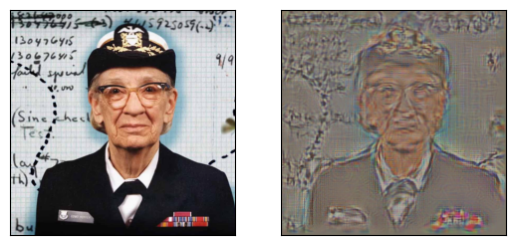

In [6]:
def alpha_prior(x, alpha=2.):
    return torch.abs(x.view(-1)**alpha).sum()


def tv_norm(x, beta=2.):
    assert(x.size(0) == 1)
    img = x[0]
    dy = img - img # set size of derivative and set border = 0
    dx = img - img
    dy[:,1:,:] = -img[:,:-1,:] + img[:,1:,:]
    dx[:,:,1:] = -img[:,:,:-1] + img[:,:,1:]
    return ((dx.pow(2) + dy.pow(2)).pow(beta/2.)).sum()


def norm_loss(input, target):
    return torch.div(alpha_prior(input - target, alpha=2.), alpha_prior(target, alpha=2.))


class Denormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


class Clip(object):
    def __init__(self):
        return

    def __call__(self, tensor):
        t = tensor.clone()
        t[t>1] = 1
        t[t<0] = 0
        return t


#function to decay the learning rate
def decay_lr(optimizer, factor):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= factor 


def get_pytorch_module(net, blob):
    modules = blob.split('.')
    if len(modules) == 1:
        return net._modules.get(blob)
    else:
        curr_m = net
        for m in modules:
            curr_m = curr_m._modules.get(m)
        return curr_m


def invert(image, network='alexnet', size=227, layer='features.4', alpha=6, beta=2, 
        alpha_lambda=1e-5,  tv_lambda=1e-5, epochs=200, learning_rate=1e2, 
        momentum=0.9, decay_iter=100, decay_factor=1e-1, print_iter=25, 
        cuda=False):

    mu = [0.485, 0.456, 0.406]
    sigma = [0.229, 0.224, 0.225]

    transform = transforms.Compose([
        transforms.Resize(size=size),
        transforms.CenterCrop(size=size),
        transforms.ToTensor(),
        transforms.Normalize(mu, sigma),
    ])

    detransform = transforms.Compose([
        Denormalize(mu, sigma),
        Clip(),
        transforms.ToPILImage(),
    ])

    model = models.__dict__[network](pretrained=True)
    model.eval()
    if cuda:
        model.cuda()

    img_ = transform(Image.open(image)).unsqueeze(0)
    print(img_.size())

    activations = []

    def hook_acts(module, input, output):
        activations.append(output)

    def get_acts(model, input): 
        del activations[:]
        _ = model(input)
        assert(len(activations) == 1)
        return activations[0]

    _ = get_pytorch_module(model, layer).register_forward_hook(hook_acts)
    input_var = Variable(img_.cuda() if cuda else img_)
    ref_acts = get_acts(model, input_var).detach()

    x_ = Variable((1e-3 * torch.randn(*img_.size()).cuda() if cuda else 
        1e-3 * torch.randn(*img_.size())), requires_grad=True)


    alpha_f = lambda x: alpha_prior(x, alpha=alpha)
    tv_f = lambda x: tv_norm(x, beta=beta)
    loss_f = lambda x: norm_loss(x, ref_acts)

    optimizer = torch.optim.SGD([x_], lr=learning_rate, momentum=momentum)

    for i in range(epochs):
        acts = get_acts(model, x_)

        alpha_term = alpha_f(x_)
        tv_term = tv_f(x_)
        loss_term = loss_f(acts)

        tot_loss = alpha_lambda*alpha_term + tv_lambda*tv_term + loss_term

        if (i+1) % print_iter == 0:
            print('Epoch %d:\tAlpha: %f\tTV: %f\tLoss: %f\tTot Loss: %f' % (i+1,
                alpha_term.data.cpu().numpy(), tv_term.data.cpu().numpy(),
                loss_term.data.cpu().numpy(), tot_loss.data.cpu().numpy()))

        optimizer.zero_grad()
        tot_loss.backward()
        optimizer.step()

        if (i+1) % decay_iter == 0:
            decay_lr(optimizer, decay_factor)

    f, ax = plt.subplots(1,2)
    ax[0].imshow(detransform(img_[0]))
    ax[1].imshow(detransform(x_[0].data.cpu()))
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
    plt.show()


invert('grace_hopper.jpg')

# if __name__ == '__main__':
#     import argparse
#     import sys
#     import traceback

#     try:
#         parser = argparse.ArgumentParser()
#         parser.add_argument('--image', type=str,
#                 default='grace_hopper.jpg')
#         parser.add_argument('--network', type=str, default='alexnet')
#         parser.add_argument('--size', type=int, default=227)
#         parser.add_argument('--layer', type=str, default='features.4')
#         parser.add_argument('--alpha', type=float, default=6.)
#         parser.add_argument('--beta', type=float, default=2.)
#         parser.add_argument('--alpha_lambda', type=float, default=1e-5)
#         parser.add_argument('--tv_lambda', type=float, default=1e-5)
#         parser.add_argument('--epochs', type=int, default=200)
#         parser.add_argument('--learning_rate', type=int, default=1e2)
#         parser.add_argument('--momentum', type=float, default=0.9)
#         parser.add_argument('--print_iter', type=int, default=25)
#         parser.add_argument('--decay_iter', type=int, default=100)
#         parser.add_argument('--decay_factor', type=float, default=1e-1)
#         parser.add_argument('--gpu', type=int, nargs='*', default=None)

#         args = parser.parse_args()

#         gpu = args.gpu
#         cuda = True if gpu is not None else False
#         use_mult_gpu = isinstance(gpu, list)
#         if cuda:
#             if use_mult_gpu:
#                 os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu).strip('[').strip(']')
#             else:
#                 os.environ['CUDA_VISIBLE_DEVICES'] = '%d' % gpu
#         print(torch.cuda.device_count(), use_mult_gpu, cuda)

#         invert(image=args.image, network=args.network, layer=args.layer, 
#                 alpha=args.alpha, beta=args.beta, alpha_lambda=args.alpha_lambda, 
#                 tv_lambda=args.tv_lambda, epochs=args.epochs,
#                 learning_rate=args.learning_rate, momentum=args.momentum, 
#                 print_iter=args.print_iter, decay_iter=args.decay_iter,
#                 decay_factor=args.decay_factor, cuda=cuda)
#     except:
#         traceback.print_exc(file=sys.stdout)
#         sys.exit(1)
